# Take-home challenge: free pizza !

Instructions: 

'You are given a dataset where each row corresponds to a request of a Reddit user, that has
triggered a free pizza action (or not). Given all the information provided, you are asked to predict
if a certain request is likely to receive a free pizza or not.
How we’ll measure successFree pizza, but no free money. Imagine you are the pizza vendor launching this awesome
marketing campaign for people to get to know your brand. You want to minimize the cost of this
campaign. Hence, you want to minimize the number of pizzas given to people who did not
deserve it.'

The key thing here is the 'deserve' part. How can we define what is a request that deserves to receive a pizza ? In our study, we will consider that every person who was offered a pizza in this dataset deserved the pizza. We want to learn what made them 'deserve' their pizzas by constructing algorithm that will predict the variable 'requester_received_pizza'.

As a pizza vendor, we want to give pizzas to people who deserve it so we have to train a powerful enough algorithm that will enable us to detect if the requests in response in our campaign deserve a pizza or not. Finally we want our algorithm to help making business decisions by deciding who should get pizzas and how much total given pizzas would be optimal. We will conduct this study in several main steps : 
- Cleaning data
- Exploring and analyzing data
- Feature engineering
- Model training and model evaluating
- Business recommendations

# 0 - Imports modules

In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz
from IPython.display import Image
from scipy import interp

import pandas as pd
pd.set_option("display.max_columns", 500)
pd.options.display.max_colwidth = 1000

# 1 - Import data

The data is in json format. We import it using Pandas.
There are 4040 observations and 32 columns.

In [2]:
# read data from json file
df = pd.read_json("data.json")
df.head(3)

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,requester_number_of_comments_in_raop_at_retrieval,requester_number_of_posts_at_request,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated,Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated,Request Colorado Springs Help Us Please,0.0000,792.420405,0.0,792.420405,0,0,0,0,0,1,0,1,0,False,[],0,1,0,1,None,nickylvst,1317852607,1317849007
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im broke until next Thursday :(,I spent the last money I had on gas today. Im broke until next Thursday :(,"[Request] California, No cash and I could use some dinner",501.1111,1122.279838,0.0,621.127072,0,1000,0,0,15,26,0,2,12,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKindness, RedditBiography, dubstep, gamecollecting, gaming, halo, i18n, techsupport]",34,4258,116,11168,None,fohacidal,1332652424,1332648824
2,N/A,0,3,0,t3_lpu5j,0,My girlfriend decided it would be a good idea to get off at Perth bus station when she was coming to visit me and has since had to spend all her money on a taxi to get to me here in Dundee. Any chance some kind soul would get us some pizza since we don't have any cash anymore?,My girlfriend decided it would be a good idea to get off at Perth bus station when she was coming to visit me and has since had to spend all her money on a taxi to get to me here in Dundee. Any chance some kind soul would get us some pizza since we don't have any cash anymore?,"[Request] Hungry couple in Dundee, Scotland would love some pizza!",0.0000,771.616181,0.0,771.616181,0,0,0,0,0,1,0,1,0,False,[],0,3,0,3,None,jacquibatman7,1319650094,1319646494


In [3]:
# get number of rows and number of columns
df.shape

(4040, 32)

In [4]:
# list columns and types
df.dtypes

giver_username_if_known                                  object
number_of_downvotes_of_request_at_retrieval               int64
number_of_upvotes_of_request_at_retrieval                 int64
post_was_edited                                           int64
request_id                                               object
request_number_of_comments_at_retrieval                   int64
request_text                                             object
request_text_edit_aware                                  object
request_title                                            object
requester_account_age_in_days_at_request                float64
requester_account_age_in_days_at_retrieval              float64
requester_days_since_first_post_on_raop_at_request      float64
requester_days_since_first_post_on_raop_at_retrieval    float64
requester_number_of_comments_at_request                   int64
requester_number_of_comments_at_retrieval                 int64
requester_number_of_comments_in_raop_at_

# 2 - Data cleaning

We first start by cleaning the requests textual content. Several operations are applied to the text:
- we remove line returns
- we lower the text
- we remove all that is after an ' in each word because those are extensions that are not semantically meaningful
- we tokenize the text, i.e. we split it into words that are separated by spaces
- we remove the punctuation
- we remove stop words like 'the', 'it', etc. because those words are not useful for text mining
- we lemmatize each word, i.e. transform it to its root form
- we remove very short words

In [5]:
def clean_text(text):
    """
    Clean text by applying several operations (lower, 
    remove unwanted characters and lemmatize).
    :param text: input string
    :return: cleaned text
    """

    # remove line returns
    text = text.replace("\n"," ")
    
    # lower text
    text = text.lower()
    
    # remove text after apostrophes
    text = re.sub("'(.*)", "", text)
    
    # tokenize text 
    text = WhitespaceTokenizer().tokenize(text)
    
    # remove puncutation
    text = [word.strip(string.punctuation) for word in text]
    
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t) for t in text]
    
    # remove words with two letters or less
    text = [t for t in text if len(t) > 2]
    
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["request_text_clean"] = df["request_text"].apply(lambda x: clean_text(x))

In [6]:
# show what clean text looks like
df[["request_text", "request_text_clean"]].head(3)

,request_text,request_text_clean
0,Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated,need food child military family really hit hard time exahusted mean help able feed family make another night ask know blessing coming whatever find heart give greatly appreciated
1,I spent the last money I had on gas today. Im broke until next Thursday :(,spent last money gas today broke next thursday
2,My girlfriend decided it would be a good idea to get off at Perth bus station when she was coming to visit me and has since had to spend all her money on a taxi to get to me here in Dundee. Any chance some kind soul would get us some pizza since we don't have any cash anymore?,girlfriend decided would good idea get perth bus station coming visit since spend money taxi get dundee chance kind soul would get pizza since


In [7]:
# create a datetime column based on UTC unix timestamp
df["datetime_utc"] = pd.to_datetime(df["unix_timestamp_of_request_utc"], unit="s")

# 3 - Exploratory Data Analysis

## 3.1 - Repartition of users between those who received a pizza and those who did not

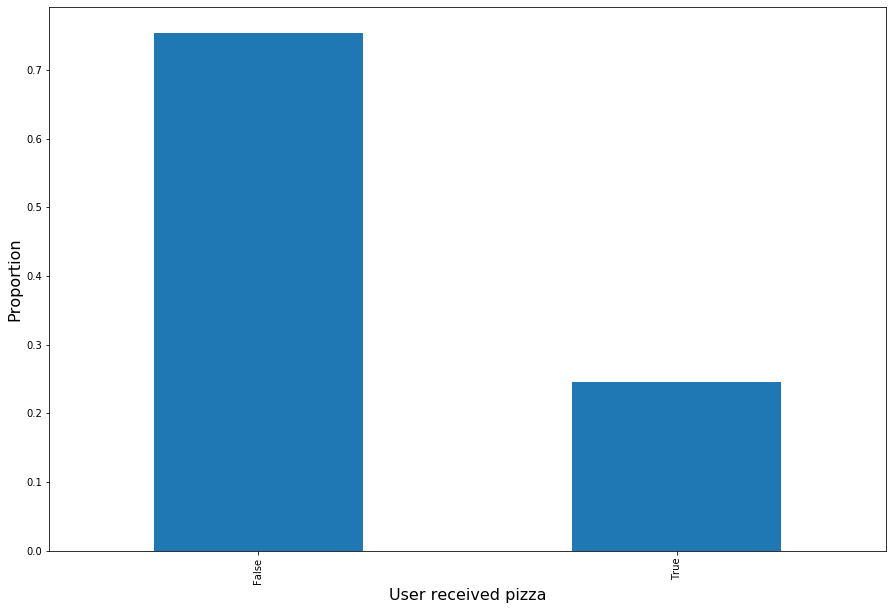

In [8]:
proportions = df["requester_received_pizza"].value_counts()/len(df)
fig = plt.figure(figsize=(15,10))
plt.xlabel("User received pizza", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
proportions.plot.bar()

## 3.2 - Data time period

In [9]:
# datetime of the first post
df["datetime_utc"].min()

Timestamp('2011-02-14 22:28:57')

In [10]:
# datetime of the last post
df["datetime_utc"].max()

Timestamp('2013-10-11 20:27:12')

## 3.3 - Cumulated number of requests over the study period

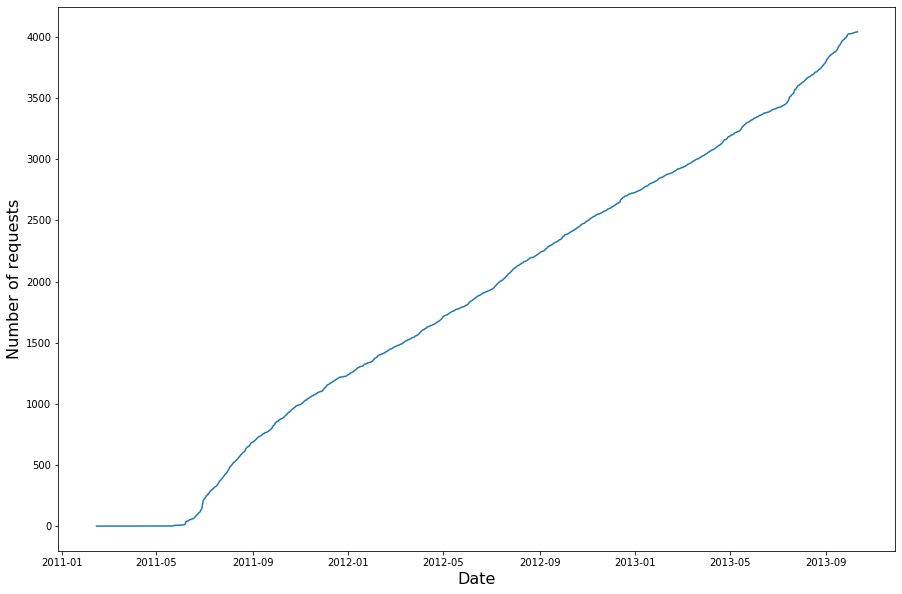

In [11]:
# evolution of cumulated number of requests
df_tmp = df.set_index("datetime_utc")
df_tmp["day"] = df_tmp.index.date
counts = df_tmp.groupby(["day"]).size()
counts = counts.sort_index()
counts_cumsum = counts.cumsum()

fig = plt.figure(figsize=(15,10))
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of requests", fontsize=16)
plt.plot(counts_cumsum)

The number of requests stays flat at first but then increases steadily during the period.

## 3.4 - Most liked or disliked requests

In [12]:
# show posts with highest upvotes-downvotes
df.sort_values(by="requester_upvotes_minus_downvotes_at_request", ascending=False)[["request_text", "requester_upvotes_minus_downvotes_at_request"]].head()

,request_text,requester_upvotes_minus_downvotes_at_request
2028,I would absolutely love some delicious pizza. That warm baked crust; the gooey cheese; the sauce that compliments both crust and cheese alike. Maybe some succulent ham or some savory pepperoni? Mouthwatering. Would anyone care to hook a brother up?,155010
325,,87911
1918,"Ok maybe it's because I only slept 3 hours, but after reading the sidebar I can't for the life of me figure out how to respond to a request. Help?",68436
2003,"My wife and I are both full time students. She has an all-day class today and will be out of the house until 7:00 PM. I'm a graphic design student with 2 major projects to finish by Monday. \n\nI feel terrible for my kids (7, 5, &amp; 4). They are doing so good entertaining themselves while we get ready for finals, and I wish I could do something for them. But we are completely broke (students, after all). Would someone mind treating them to some delicious pizza?",32025
516,I'm located in TN. Thanks in advance! Looking forward to fulfilling some requests on this sub as well.,30560


In [13]:
# show posts with lowest upvotes-downvotes
df.sort_values(by="requester_upvotes_minus_downvotes_at_request", ascending=True)[["request_text", "requester_upvotes_minus_downvotes_at_request"]].head()

,request_text,requester_upvotes_minus_downvotes_at_request
2151,"I recently lost my job, and I have been living off chef boyardee and ramen noodles for the past couple weeks and a pizza would really brighten my mood and help me alot, can anyone help!?",-173
3468,Not gonna give you a very long sap story; just a poor college kid who would love an upturn of his day.\n\nThanks!,-67
3598,"TBH, I never knew this was here on Reddit, but imho only, that information came at the perfect time.. 2 years and 16 days ago I was hit from behind on my cycle at a Stop Sign. The ER doctor told me that if I had been wearing a helmet, the force of impact was so great, I would have been killed on the spot. (extra weight (avg 4-6 lbs.) of the helmet would have caused my neck to snap and kill me)\n\nJoining Reddit was one of the many things suggest to me, to help re-train my brain and thought process. To everyone I have talked/debated with, let me take a second here and say Thank You. \n\nBut back to the reason for the post, may I kindly ask for a pizza? As it has been a long road back to somewhat normal for me and thinking about someone I don't know, caring enough to say, Hey, let's send this guy a pizza just because, well, it is so damn cool. I'm not sure what happens next, but to the person if they decide to say hey I can do that, please know from the bottom of my heart, I am grate...",-56
3781,"Hey reddit, ive just been diagnosed as HIV positive thanks to my prostitute of a GF, and i mean actual prostitute. I was stupid enough to stay with her once i found out, she gave me a list of promises which i bought into and im paying the price. I have had to drop out of my medicine degree at uni thanks to the diagnosis and my friends are already treating me differently like an invalid - my best friends are all out tonight and havent invited me and think i dont know. I have no career, a huge student debt and a bottle of vodka to keep me company tonight. Would really appreciate a nice pizza before i have to face what happend with my life. If anyone can help please do.\n\nthanks reddit and sorry about my whinging",-39
2844,"I don't even know where to begin, I am soo hungry and depressed can't even get out of bed, was supposed to start a new job over a month ago for a start up but once again date got moved. Reddit please help me? All I ask for is enough so I can go get something to eat for a day or two.\n(just cause I am sure I will be called out for it, yes this is a throw away I am very private about my life but if an absolute must I will PM some one my actual user name)\noh yea location, is IL",-18


It seems that the most liked requests are not necessarily the ones posted by people who are really in need for a pizza. On the contrary, the most disliked posts are made by people who seem really desperate.

## 3.5 - Most frequent words

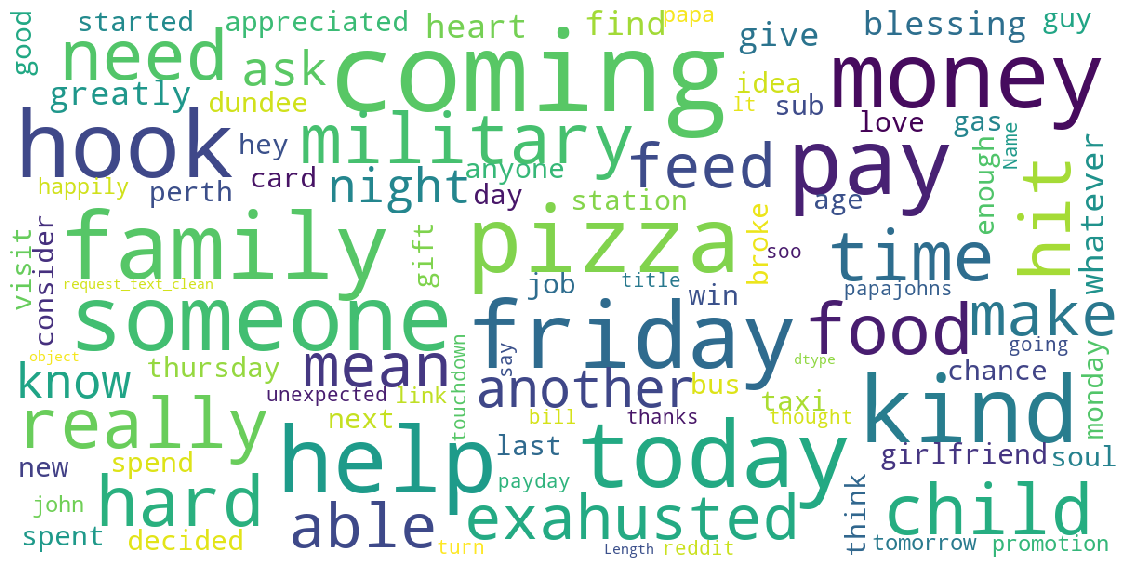

In [14]:
def show_wordcloud(data, title = None):
    """
    Plot a wordcloud computed on the input texts.
    :param data: list of input texts
    """
    
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# plot wordcloud
show_wordcloud(df["request_text_clean"])

# 4 - Feature engineering

After this first exploration, we can select and construct new features that will help us to predict more accurately if a request deserves to receive a pizza.

## 4.1 - Remove non relevant features

We start by dropping the columns that are computed at retrieval because those metrics were obtained at the end of the study period (end of 2013). Hence it does contain information that was not available at the time of the requests and should not be used for prediction.

In [15]:
# select only relevant data : drop data at retrieval
cols = ["request_text", "request_title",  
        "requester_number_of_comments_in_raop_at_request", "requester_number_of_posts_on_raop_at_request", 
        "requester_upvotes_minus_downvotes_at_request", "requester_number_of_posts_at_request",
        "requester_upvotes_plus_downvotes_at_request", "request_text_clean",
        "requester_account_age_in_days_at_request", "requester_number_of_comments_at_request",
        "requester_number_of_subreddits_at_request", "requester_received_pizza"
       ]

df = df[cols]

## 4.2 - Sentiment analysis

We then compute sentiment analysis metrics about the requests using a tool called Vader from NLTK.
The idea here is that a request that is very sad may deserve more the pizza because it may indicate that the user is in a very bad situation.

The sentiment scores are computed on raw text data because punctation have an impact on the sentiment scores.

In [16]:
# add sentiment analysis columns
sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["request_text"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

# drop neutral score because colinear with positive and negative sentiment scores
df = df.drop(["neu"], axis=1)

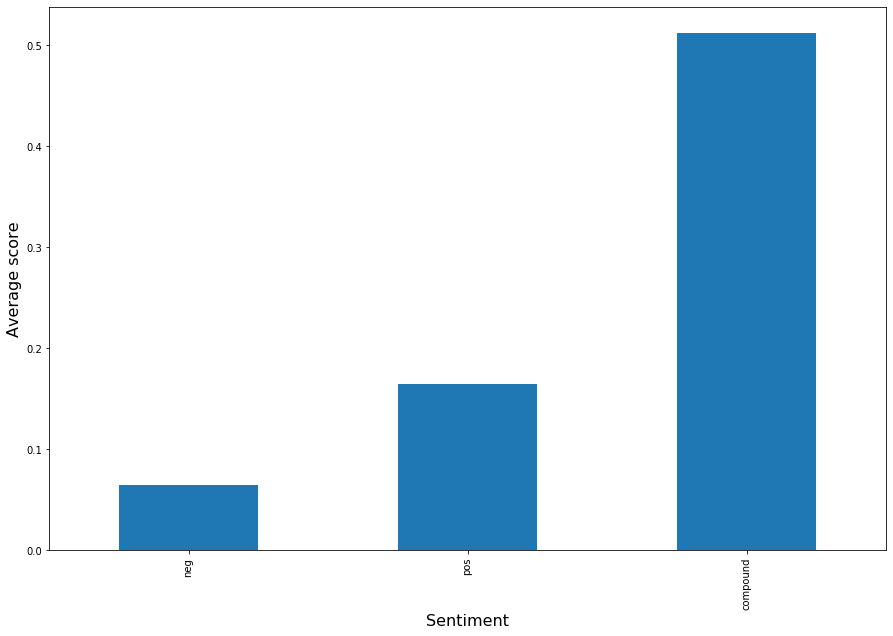

In [17]:
# plot average sentiment scores
topic_average_scores = df[["neg", "pos", "compound"]].mean()
fig = plt.figure(figsize=(15,10))
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average score", fontsize=16)
topic_average_scores.plot.bar()

Suprisingly, the requests have a low negativity score on average.

## 4.3 - Topic modeling

We can also extract from the text information related to topics. Indeed a post that talks about poverty for example may have a higher probability to deserve a pizza.

Several methods are popular among the topic modelling field, the two most popular are :
- LDA : Latent Dirichlet Allocation
- NMF : Non-negative Matrix Factorization

Here we decided to use the Non-negative Matrix factorization because we observed that the topics extracted with this method were more relevant.

Some results obtained by the University of British columbia have similar conclusions :
https://wiki.ubc.ca/Course:CPSC522/A_Comparison_of_LDA_and_NMF_for_Topic_Modeling_on_Literary_Themes?fbclid=IwAR1UDxVuzSkR1FYvU5MaqWaS3Z1zblTPbU7nY7vgSORDdS01VWe9WaCLT94

We first transform cleaned textual data into a TF-IDF matrix.
Then we use the NMF algorithm to obtain topic scores for each document.

In [18]:
def nmf_train(list_input_text, print_results):
    """
    Train a NMF model on the input texts.
    :param list_input_text: list of input texts
    :param print_results: boolean : True if results should be printed, False otherwise
    :return: tfidf_vectorizer : tfidf vectorizer fitted on input data
    :return: NMF model fitted on input data
    """
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(list_input_text)
    nmf = NMF(n_components=5, random_state=1).fit(tfidf)
    
    if print_results:
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        print_top_words(nmf, tfidf_feature_names, 10)
    
    return(tfidf_vectorizer, nmf)

def print_top_words(model, feature_names, n_top_words):
    """
    Print the words that are the most important for each topic obtained using Non-negative Matrix Factorization.
    :param model: trained NMF model
    :param feature_names: features of the TF-IDF matrix : correspond to the words of the vocabulary
    :param n_top_words: number of words to show for each topic
    """
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #{}: ".format(topic_idx)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        
def nmf_predict_df(nmf, tfidf_vectorizer, list_input_text):
    """
    Predict topic scores for each input text
    :param nmf: fitted NMF model
    :param tfidf_vectorizer: fitted tfidf vectorizer
    :param list_input_text: list of input texts on which to predict topic scores
    :return: pandas DataFrame with predictions for each input text
    """

    predictions = nmf.transform(tfidf_vectorizer.transform(list_input_text))
    predictions_df = pd.DataFrame(predictions, columns=["topic_{}_score".format(i) for i in range(len(predictions[0]))])
    
    predictions_df = predictions_df.fillna(0)
    return(predictions_df)

In [19]:
# apply NMF and get the words that are the most important in each topic
tfidf_vectorizer, nmf = nmf_train(df["request_text_clean"], print_results=True)
predict_df = nmf_predict_df(nmf, tfidf_vectorizer, df["request_text_clean"])

Topic #0: pizza would love really help like thanks tonight could anyone
Topic #1: hey guy raop reddit everyone redditors first time everybody roap
Topic #2: week job get money work got last month time food
Topic #3: hello raop friend reddit everyone fellow name redditors old year
Topic #4: title say pretty much like yeah basically else exactly act


Given the most important words for each topic, we can assign a label to each of them :
- Topic 0 : Request 
- Topic 1 : Greetings to the Reddit community
- Topic 2 : Work and money
- Topic 3 : Sympathy to the reddit community
- Topic 4 : General words

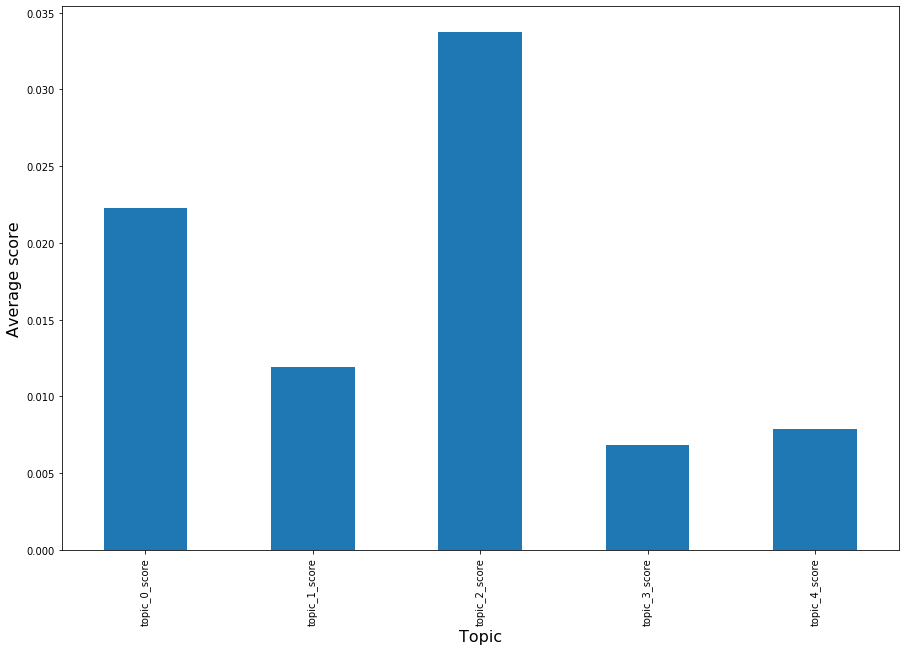

In [20]:
# plot average topic scores
topic_average_scores = predict_df.mean()
fig = plt.figure(figsize=(15,10))
plt.xlabel("Topic", fontsize=16)
plt.ylabel("Average score", fontsize=16)
topic_average_scores.plot.bar()

On average, requests have higher Topic 2 (work and money) scores and Topic 0 (request) scores. This seems logical because those topics are usually used to justify the request for a pizza.

We do not directly add those topic scores to our dataframe because this topic extraction was computed using the whole dataset. Whereas we need to only use the train data to compute training features.

## 4.4 - Other text features

Finally we add a few other text features based on the request text and the request title :
- number of characters
- number of words
- number of exclamation marks
- number of uppercase characters
- average word length

In [21]:
# compute additional features for the request text and the request title

df["request_text_nb_chars"] = df["request_text"].apply(lambda x: len(x))
df["request_text_nb_words"] = df["request_text"].apply(lambda x: len(WhitespaceTokenizer().tokenize(x)))
df["request_text_nb_exclamation_marks"] = df["request_text"].apply(lambda x: x.count("!"))
df["request_text_nb_uppercase_characters"] = df["request_text"].apply(lambda x: sum(1 for c in x if c.isupper()))
df["request_text_average_word_length"] = df["request_text"].apply(lambda x: np.mean([len(w) for w in WhitespaceTokenizer().tokenize(x)]))

df["request_title_nb_chars"] = df["request_title"].apply(lambda x: len(x))
df["request_title_nb_words"] = df["request_title"].apply(lambda x: len(WhitespaceTokenizer().tokenize(x)))
df["request_title_nb_exclamation_marks"] = df["request_text"].apply(lambda x: x.count("!"))
df["request_title_nb_uppercase_characters"] = df["request_text"].apply(lambda x: sum(1 for c in x if c.isupper()))
df["request_title_average_word_length"] = df["request_text"].apply(lambda x: np.mean([len(w) for w in WhitespaceTokenizer().tokenize(x)]))

/home/jonathan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


requester_received_pizza
False    72.559750
True     92.757545
Name: request_text_nb_words, dtype: float64


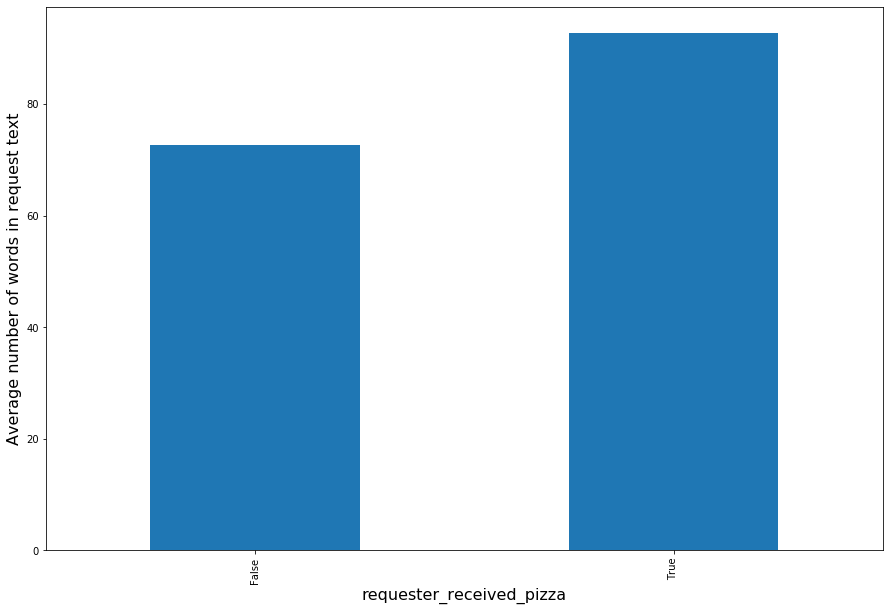

In [22]:
df_tmp = df.groupby(["requester_received_pizza"])["request_text_nb_words"].mean()

fig = plt.figure(figsize=(15,10))
plt.xlabel("User received pizza", fontsize=16)
plt.ylabel("Average number of words in request text", fontsize=16)
df_tmp.plot.bar()
print(df_tmp)

The average number of words in a request is quite higher for the ones that actually received a pizza. This could indicate that longer requests have a higher probability of receiving a pizza. This seems logical as a long request gives more opportunity to justify and convince other people.

In [23]:
# fill na data for features computed on blank text
df = df.fillna(0)

# 5 - Model training and testing

Now that we have enriched our dataset with additional features, we can build and evaluate a predictive model.
We will do this using K-fold cross-validation as this will give us more consistent evaluation results.
We chose to use a simple type of model : classification trees.
If our model is going to be used by a pizza vendor, we want it to be effective but also easy to explain.

# 5.1 - Statistical evaluation

In this first part, we will evaluate our model using the AUC ROC (Area Under Curve ROC). This metric is good to evaluate how a model performs with different prediction thresolds.

In [24]:
def k_fold_train_evaluation(df, list_features, clf, print_results):
    """
    Train and evaluate models (ROC curve) using k-fold cross validation.
    :param df: input data to use for model training and testing
    :param list_features: list of features to use to train the model
    :param clf: type of classifier to use for prediction
    :param print_results: boolean : True if results should be printed, False otherwise
    :return: tfidf_vectorizer : tfidf vectorizer fitted on input data
    :return: NMF model fitted on input data
    """
    
    X = df[list_features]
    y = df[label]

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    feature_importances = []

    probas = []
    y_true = []


    kf = KFold(n_splits=5)

    i = 0

    for train, test in kf.split(X):
                
        X_train = X.loc[train]
        y_train = y.loc[train]
        X_test = X.loc[test]
        y_test = y.loc[test]
        
        
        # train nmf model only on train set
        tfidf_vectorizer, nmf = nmf_train(X_train["request_text_clean"], print_results=False)
        predict_df = nmf_predict_df(nmf, tfidf_vectorizer, X_train["request_text_clean"]).fillna(0)
        predict_df.index = X_train.index
        X_train = pd.concat([X_train, predict_df], axis=1)
        X_train = X_train.drop(["request_text_clean"], axis=1)
        
        tfidf_vectorizer, nmf = nmf_train(X_test["request_text_clean"], print_results=False)
        predict_df = nmf_predict_df(nmf, tfidf_vectorizer, X_test["request_text_clean"]).fillna(0)
        predict_df.index = X_test.index
        X_test = pd.concat([X_test, predict_df], axis=1)
        X_test = X_test.drop(["request_text_clean"], axis=1)
        
        list_features = X_train.columns

        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
        feature_importances.append(clf.feature_importances_)

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        probas.append(list(probas_[:, 1]))
        y_true.append(list(y_test))

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        if print_results:
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    if print_results:

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Random', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('Receiver operating characteristic', fontsize=16)
        plt.legend(loc="lower right")
        plt.show()

        feature_importance_df = pd.DataFrame(feature_importances).transpose()
        feature_importance_df.columns = ["importance1", "importance2", "importance3", "importance4", "importance5"]
        feature_importance_df["avg_importance"] = feature_importance_df.mean(axis=1)

        feature_importance_df["feature"] = list_features
        print(feature_importance_df.sort_values("avg_importance", ascending=False).head(10))
    
    return(np.mean(aucs))

In [25]:
# define columns to use for model training and testing
label = "requester_received_pizza"
ignore_cols = ["request_text", "request_title"] + [label]
features = [c for c in df.columns if c not in ignore_cols]

# convert label boolean column to numerical column
df[label] = df[label].astype(int)

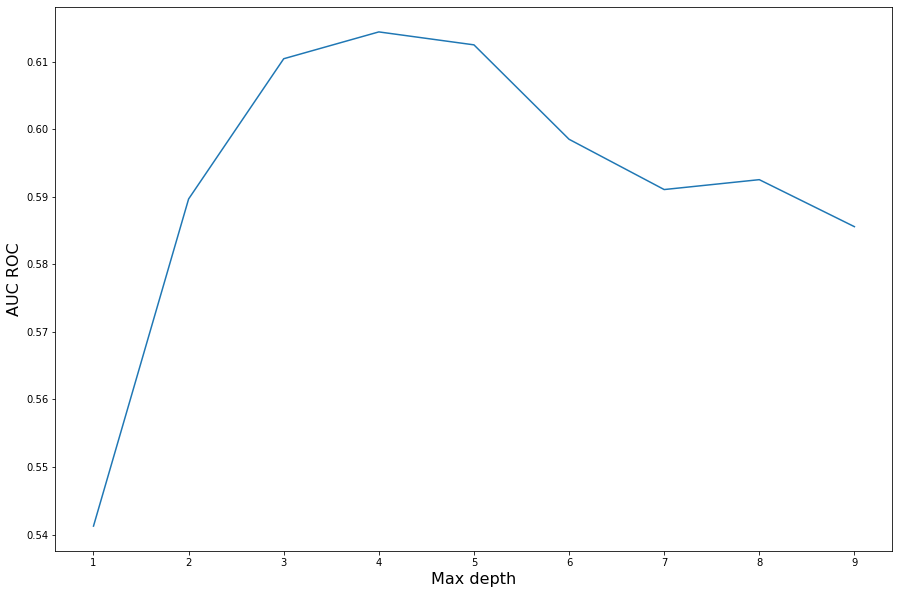

In [26]:
# use a classification tree for prediction
# get ROC AUC results for several values of the max_depth parameter

aucs_results = []
for i in range(1, 10):
    clf = DecisionTreeClassifier(max_depth=i, random_state=0)
    aucs_results.append(k_fold_train_evaluation(df, features, clf, print_results=False))

# plot results
fig = plt.figure(figsize=(15,10))
plt.xlabel("Max depth", fontsize=16)
plt.ylabel("AUC ROC", fontsize=16)
plt.plot(range(1, 10), aucs_results)

The most important parameter for a classification tree is the maximum depth. A tree with a small depth will not be able to capture well enough the interactions between the features and the label. On the other hand, a tree with too much depth will start to capture noise in the train data and will not generalize well its results to another dataset.

Here we can see that the AUC ROC rises significantly until the depth 3. Then it starts to fall back again after the depth 5 because of overfitting.

We will use the depth value 3 as it has one of the best AUC ROC values and it makes our prediction tree quite simple.

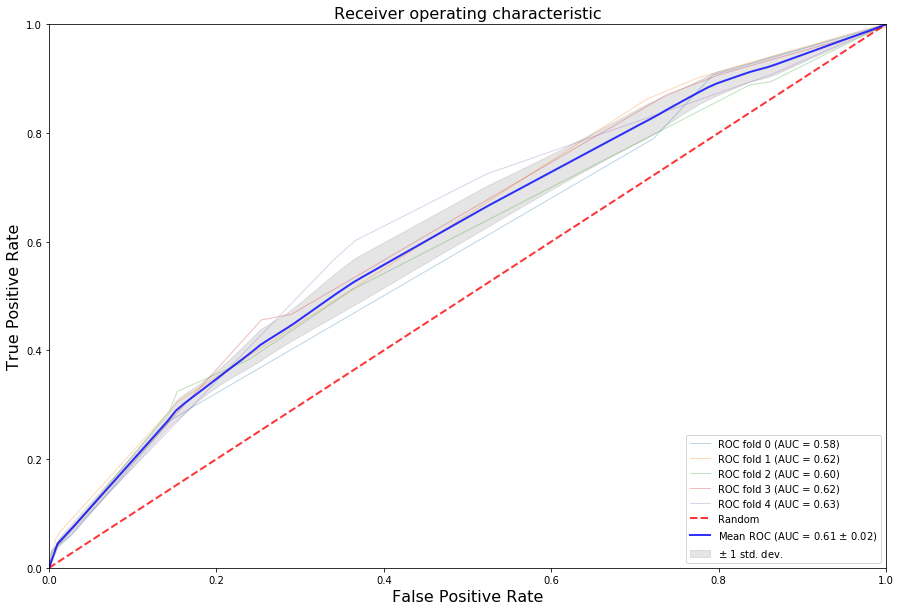

    importance1  importance2  importance3  importance4  importance5  \
0      0.374438     0.254004     0.177435     0.321595     0.419187   
11     0.239651     0.305088     0.358601     0.331396     0.303150   
2      0.000000     0.000000     0.174652     0.261337     0.117276   
5      0.169923     0.168524     0.000000     0.000000     0.000000   
4      0.086138     0.102575     0.122975     0.000000     0.000000   
10     0.070572     0.000000     0.133415     0.000000     0.000000   
16     0.059278     0.041826     0.000000     0.000000     0.064170   
7      0.000000     0.000000     0.000000     0.000000     0.096217   
1      0.000000     0.090884     0.000000     0.000000     0.000000   
21     0.000000     0.037097     0.000000     0.043386     0.000000   

    avg_importance                                          feature  
0         0.309332  requester_number_of_comments_in_raop_at_request  
11        0.307577                            request_text_nb_chars  
2       

0.610420612426035

In [27]:
# plot ROC curve for best parameter, on the 5 folds of the cross validation
# print the most important features
rcParams["figure.figsize"] = 15, 10
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
k_fold_train_evaluation(df, features, clf, print_results=True)

The most important features are mostly related to the activeness of the users, the length of their request and the votes on their request.

Sentiment features and topic modelling features have a fairly small importance in our model.

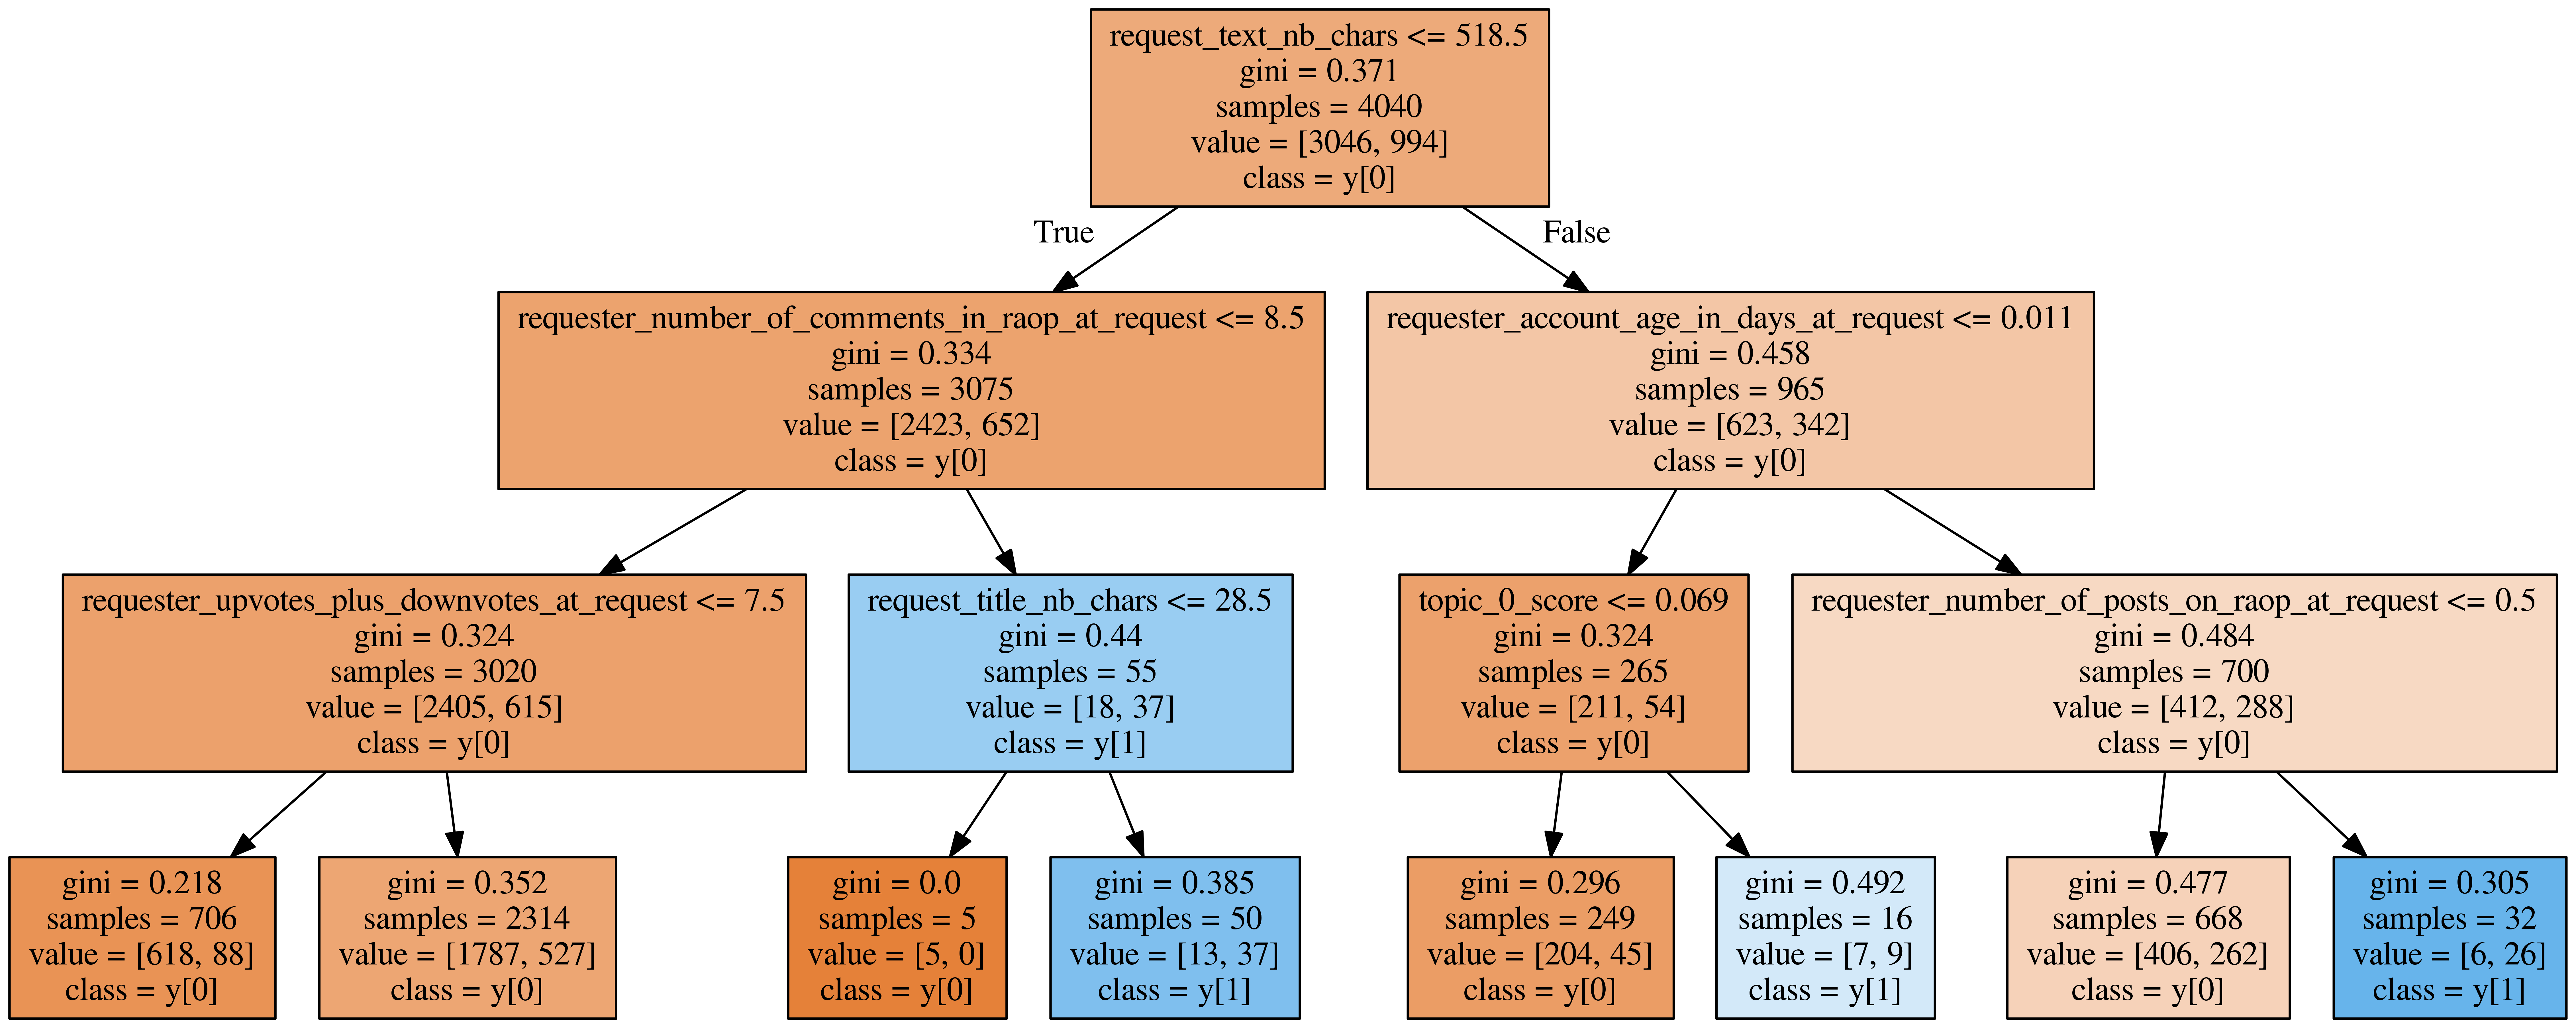

In [28]:
# print the classification tree
clf = DecisionTreeClassifier(max_depth=3, random_state=0)

X_train = df[features]
y_train = df[label]

tfidf_vectorizer, nmf = nmf_train(X_train["request_text_clean"], print_results=False)
predict_df = nmf_predict_df(nmf, tfidf_vectorizer, X_train["request_text_clean"]).fillna(0)
predict_df.index = X_train.index
X_train = pd.concat([X_train, predict_df], axis=1)
X_train = X_train.drop(["request_text_clean"], axis=1)
list_features = X_train.columns
        
clf.fit(X_train, y_train)


dot_data = export_graphviz(clf, out_file="tree.dot", feature_names=list_features, class_names=True, filled = True)

!dot -Tpng tree.dot -o tree.png -Gdpi=600

Image(filename = 'tree.png')

Our final classification tree is quite easy to understand, and anybody could use it to predict for a new request if he should offer a pizza or not. 

# 5.2 - Business evaluation and recommendations

The previous evaluation told us how good our model is for prediction.
We also need to translate this into a business logic to answer those questions : 
- How much money will this campaign cost us ?
- What is the optimal proportion of users that should get a free pizza ?

Let's assume that producing a pizza costs 5€, and that giving a pizza to a client that deserves it will generate earnings of 15€ in the future (the client will promote the brand and buy again in our pizzeria).

In this case, we want to target a high proportion of deserving clients. If we target too much people, we will start to target clients that are not deserving and we will lose money on our campaign.

In [29]:
def k_fold_train_evaluation_business(df, list_features, clf, target_ratio=0.1, pizza_price=5, estimated_earnings_per_good_client = 15, verbose=False):
    """
    Train and evaluate models (business metrics) using k-fold cross validation.
    :param df: input data to use for model training and testing
    :param list_features: list of features to use to train the model
    :param clf: type of classifier to use for prediction
    :param target_ratio: proportion of requests that will receive a pizza
    :param pizza_price: pizza production price
    :param estimated_earnings_per_good_client: earnings that will be generated in the future if a pizza is offered to a relevant request
    :param verbose: boolean : True if business results should be printed, False otherwise
    :return: campaign precision
    :return: potential earnings of the campaign
    """
    
    X = df[list_features]
    y = df[label]

    probas = []
    y_true = []

    kf = KFold(n_splits=5)

    for train, test in kf.split(X):
        
        X_train = X.loc[train]
        y_train = y.loc[train]
        X_test = X.loc[test]
        y_test = y.loc[test]
        
        
        # train nmf model only on train set
        tfidf_vectorizer, nmf = nmf_train(X_train["request_text_clean"], print_results=False)
        predict_df = nmf_predict_df(nmf, tfidf_vectorizer, X_train["request_text_clean"]).fillna(0)
        predict_df.index = X_train.index
        X_train = pd.concat([X_train, predict_df], axis=1)
        X_train = X_train.drop(["request_text_clean"], axis=1)
        
        tfidf_vectorizer, nmf = nmf_train(X_test["request_text_clean"], print_results=False)
        predict_df = nmf_predict_df(nmf, tfidf_vectorizer, X_test["request_text_clean"]).fillna(0)
        predict_df.index = X_test.index
        X_test = pd.concat([X_test, predict_df], axis=1)
        X_test = X_test.drop(["request_text_clean"], axis=1)
        
        list_features = X_train.columns

        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

        probas.append(list(probas_[:, 1]))
        y_true.append(list(y_test))
        
    flatten_probas = [item for sublist in probas for item in sublist]
    flatten_y_true = [item for sublist in y_true for item in sublist]
        
    eval_df = pd.DataFrame([flatten_probas, flatten_y_true]).T 
    eval_df.columns=["probas", "label"]
    eval_df = eval_df.sort_values(by="probas", ascending=False)
    
    eval_df_targeted = eval_df.head(int(len(eval_df)*target_ratio))
    eval_df_targeted_random = eval_df.sample(n=int(len(eval_df)*target_ratio), replace=False, random_state=0)
    
    nb_pizzas_given = len(eval_df_targeted)
    positives = sum(eval_df_targeted["label"])
    
    random_positives = sum(eval_df_targeted_random["label"])
    
    precision = positives/nb_pizzas_given
    random_precision = random_positives/len(eval_df_targeted_random)
    potential_earnings = positives*estimated_earnings_per_good_client - nb_pizzas_given*pizza_price
    
    if verbose:
        print("{} pizzas given".format(nb_pizzas_given))
        print("{} people deserved the pizza".format(positives))
        print("{} people did not deserve the pizza".format(nb_pizzas_given - positives))
        print("precision : {}".format(precision))
        print("random precision : {}".format(random_precision))
        print("total money spent : {}€".format(nb_pizzas_given*pizza_price))
        print("total money lost on wrong clients : {}€".format((nb_pizzas_given - positives)*pizza_price))
        print("potential total earnings of the campaign :{}€".format(potential_earnings))
    
    else:
        return(precision, potential_earnings)

In [30]:
# for a range of target ratios, compute precision and potential campaign earnings

precisions = []
potential_earnings = []
boundaries = [0.01, 1]
for ratio in np.arange(boundaries[0], boundaries[1], 0.05):
    p, pe = k_fold_train_evaluation_business(df, features, clf, target_ratio=ratio, verbose=False)
    precisions.append(p)
    potential_earnings.append(pe)

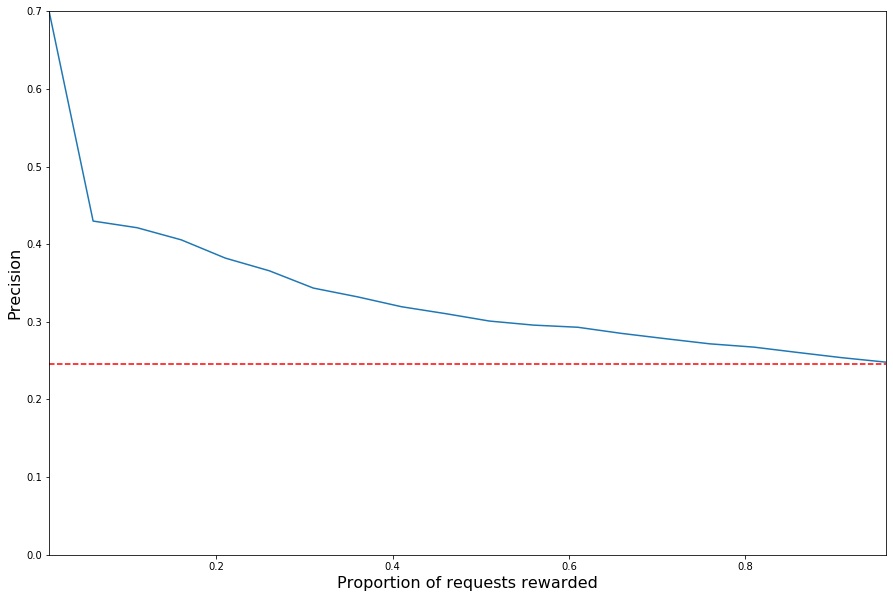

In [31]:
# plot the evolution of precision compared to a random baseline

axes = plt.gca()
axes.set_xlim([np.min(np.arange(boundaries[0], boundaries[1], 0.05)),np.max(np.arange(boundaries[0], boundaries[1], 0.05))])
axes.set_ylim([0,np.max(precisions)])
plt.xlabel("Proportion of requests rewarded", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.plot(np.arange(boundaries[0], boundaries[1], 0.05), precisions)
plt.axhline(y=sum(df["requester_received_pizza"])/len(df), color='red', linestyle='--')

The precision decreases rapidly at the beginning and steadily after, until it reaches the random baseline (in red) in the case of giving pizzas to everybody.

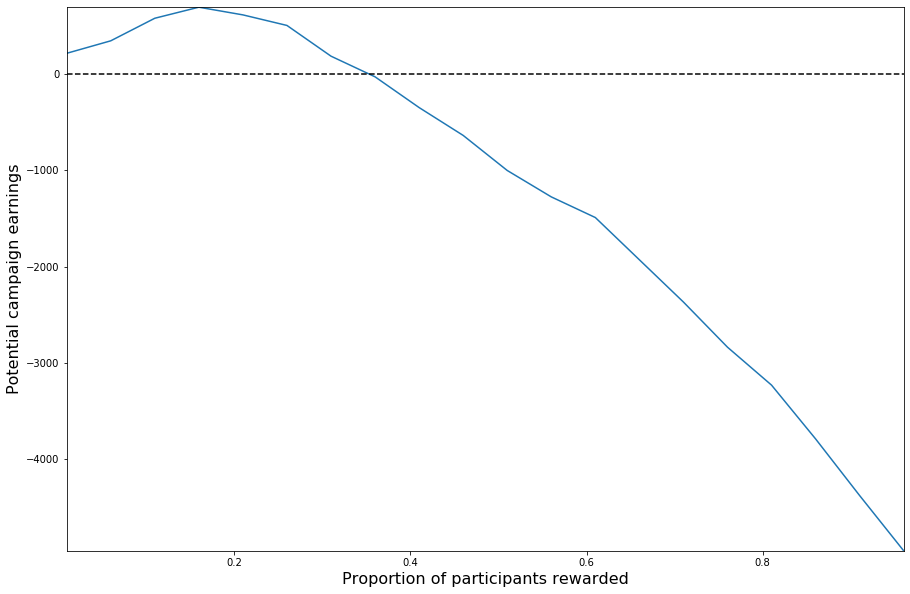

In [32]:
# plot the evolution of estimated earnings depending on targeting ratio

axes = plt.gca()
axes.set_xlim([np.min(np.arange(boundaries[0], boundaries[1], 0.05)),np.max(np.arange(boundaries[0], boundaries[1], 0.05))])
axes.set_ylim([np.min(potential_earnings),np.max(potential_earnings)])
plt.xlabel("Proportion of participants rewarded", fontsize=16)
plt.ylabel("Potential campaign earnings", fontsize=16)
plt.plot(np.arange(boundaries[0], boundaries[1], 0.05), potential_earnings)
plt.axhline(y=0, color='black', linestyle='--')

Using the previous hypothesis, we can compute how much clients we would have rightly given pizzas and the ones we were wrong about, depending on the proportion of rewarded clients.

As our precision is high in the beginning, we make a high number of good predictions and our campaign is generating some increasing earnings. After a certain proportion of participants rewarded, the potential campaign earnings start to decrease because our precision is lower.

In [33]:
# print business results for optimum point
optimal_target_ratio = np.arange(boundaries[0], boundaries[1], 0.05)[np.argmax(potential_earnings)]
print("optimal target ratio : {}".format(optimal_target_ratio))
k_fold_train_evaluation_business(df, features, clf, target_ratio=optimal_target_ratio, verbose=True)

optimal target ratio : 0.16000000000000003
646 pizzas given
262.0 people deserved the pizza
384.0 people did not deserve the pizza
precision : 0.4055727554179567
random precision : 0.24613003095975233
total money spent : 3230€
total money lost on wrong clients : 1920.0€
potential total earnings of the campaign :700.0€


The results of a campaign with an optimal pizza rewarding ratio is shown above. This business information is very useful as we can use it to infer what would be the outcome of our marketing campaign. We can see that our precicion is much higher than the random baseline.

# 6. Conclusion

We were able to give business recommendations using a predictive algorithm on this RAOP data. Feature engineering was really important in order to increase the prediction power of our classification tree. Using a simple algorithm allowed us to get a model easily understandeable and which also gives good performance results.

The pizza vendor can now launch his campaign and use our algorithm to give pizzas to deserving clients, and give the right total amount of pizzas !